In [18]:
import pandas as pd
import datetime
import numpy as np
from copy import deepcopy
from collections import defaultdict

# angshuman's functions
from HistoricalData.getData import getNearestEpaData, getNearestNoaaData, get_data

In [2]:
df = pd.read_csv("xfile_rf.csv")
df.head()

,Unnamed: 0,created,lat,lon,x,y,epa_pm25_value,ndvi,wind_x,wind_y,...,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,neighbor_21,neighbor_22,neighbor_23,temperature,humidity
0,0,201909010000,37.824436,-122.534739,0,34,5.1,-2000,1.215537,-6.893654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.5,49.0
1,1,201909010000,37.827984,-122.534739,0,35,5.1,-2000,1.215537,-6.893654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.5,49.0
2,2,201909010000,37.831531,-122.534739,0,36,5.1,-2000,1.215537,-6.893654,...,NaN,4.3,NaN,NaN,NaN,NaN,NaN,5.42,80.5,49.0
3,3,201909010000,37.835079,-122.534739,0,37,5.1,5159,1.215537,-6.893654,...,NaN,NaN,2.97,5.42,4.30,NaN,NaN,NaN,80.5,49.0
4,4,201909010000,37.838626,-122.534739,0,38,5.1,7053,1.215537,-6.893654,...,2.91,NaN,NaN,NaN,2.97,NaN,2.62,4.30,84.0,45.0


In [4]:
df.drop(columns = ['neighbor_0', 'neighbor_1',
       'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5', 'neighbor_6',
       'neighbor_7', 'neighbor_8', 'neighbor_9', 'neighbor_10', 'neighbor_11',
       'neighbor_12', 'neighbor_13', 'neighbor_14', 'neighbor_15',
       'neighbor_16', 'neighbor_17', 'neighbor_18', 'neighbor_19',
       'neighbor_20', 'neighbor_21', 'neighbor_22', 'neighbor_23', 'Unnamed: 0'], inplace = True)

In [5]:
df.head()

,created,lat,lon,x,y,epa_pm25_value,ndvi,wind_x,wind_y,elevation,temperature,humidity
0,201909010000,37.824436,-122.534739,0,34,5.1,-2000,1.215537,-6.893654,17,80.5,49.0
1,201909010000,37.827984,-122.534739,0,35,5.1,-2000,1.215537,-6.893654,0,80.5,49.0
2,201909010000,37.831531,-122.534739,0,36,5.1,-2000,1.215537,-6.893654,0,80.5,49.0
3,201909010000,37.835079,-122.534739,0,37,5.1,5159,1.215537,-6.893654,55,80.5,49.0
4,201909010000,37.838626,-122.534739,0,38,5.1,7053,1.215537,-6.893654,132,84.0,45.0


In [15]:
# get our grid points
grid = pd.read_csv("500m_grid.csv")

In [11]:
ts_ = datetime.datetime.strptime('201909010000', '%Y%m%d%H%M')


UP_LEFT = (38.008050, -122.536985)    
UP_RIGHT = (38.008050, -122.186437)   
DOWN_RIGHT = (37.701933, -122.186437) 
DOWN_LEFT = (37.701933, -122.536985)  
START_DATE = ts_.strftime("%Y/%m/%d") 
END_DATE = ts_.strftime("%Y/%m/%d")   
START_HOUR = str(ts_.hour)
END_HOUR = str(ts_.hour + 1)

full_hour_PA_data = get_data(UP_LEFT, UP_RIGHT, DOWN_RIGHT, 
                             DOWN_LEFT, START_DATE, END_DATE, START_HOUR, END_HOUR)

In [13]:
PA_data_at_t = full_hour_PA_data[(full_hour_PA_data.hour == '00') & 
                                 (full_hour_PA_data.minute == '00')]
PA_data_at_t.shape

(165, 64)

In [16]:
# map every incoming PA sensor to our grid
# note: this method is slow but is OK if you're only doing one timestep at a time
# do not use this method for processing whole year at once

def get_coords(line):
    box = grid[(grid.min_lat < line.lat) & (grid.max_lat > line.lat) & 
               (grid.min_lon < line.lon) & (grid.max_lon > line.lon)]
    if box.shape[0] != 1:
        return np.nan, np.nan
    return box.iloc[0, 4], box.iloc[0, 5] # x,y

PA_data_at_t['xy'] = PA_data_at_t.apply(get_coords, axis = 1)

In [21]:
xy_mapping = defaultdict(list)

_ = PA_data_at_t.apply(lambda l: xy_mapping[l.xy].append(l.name), axis =1)

In [25]:
def get_neighbors(line, train_df):
    """
    Inputs: a df line containing x-y coordinates, and a reference df (train_df) 
            to pull neighbor observations
    Outputs: vector of length 24 corresponding to surrounding neighbor observations
    """
    
    neighbors = np.zeros((24))
    
    c = 0
    for i in range(-2,3):
        for j in range(-2,3):
            if i == 0 and j == 0 : continue
            
            n = xy_mapping[(line.x+i, line.y+j)] # get row #s in train_df for that xy block
            
            if n:
                neighbors[c] = train_df.loc[n, '2_5um'].mean()
            c += 1
    
    return neighbors

In [33]:
%%time
df_neighbors = df.apply(lambda x: get_neighbors(x, PA_data_at_t), axis = 1)

CPU times: user 4.7 s, sys: 7.25 ms, total: 4.71 s
Wall time: 4.71 s


In [45]:
new_cols = [f'neighbor_{m}' for m in range(0,24)]
nns = []

for row in df_neighbors:
    record = {}
    for i, col in enumerate(new_cols):
        record[col] = row[i]
    nns.append(record)

df_tmp = pd.concat((df, pd.DataFrame(nns)), axis =1) 

In [46]:
## wait, do I still have rows over the ocean
def in_water(line):
    box = grid[(grid.x == line.x) & (grid.y == line.y)].reset_index()
    
    return box.loc[0, 'in_water']

df_tmp['in_water'] = df_tmp.apply(in_water, axis = 1)

In [49]:
feature_names = ['epa_pm25_value', 'humidity', 'temperature', 'wind_x', 'wind_y', 'ndvi', 'elevation'] + [f'neighbor_{m}' for m in range(0,24)]

df_final = df_tmp[~df_tmp.in_water][feature_names]

In [50]:
df_final.shape

(4244, 31)

## loading model from file

In [54]:
from joblib import load

rf = load("nn/201901103_RF.joblib")

In [56]:
df_final.isnull().any()

epa_pm25_value    False
humidity           True
temperature        True
wind_x            False
wind_y            False
ndvi              False
elevation         False
neighbor_0        False
neighbor_1        False
neighbor_2        False
neighbor_3        False
neighbor_4        False
neighbor_5        False
neighbor_6        False
neighbor_7        False
neighbor_8        False
neighbor_9        False
neighbor_10       False
neighbor_11       False
neighbor_12       False
neighbor_13       False
neighbor_14       False
neighbor_15       False
neighbor_16       False
neighbor_17       False
neighbor_18       False
neighbor_19       False
neighbor_20       False
neighbor_21       False
neighbor_22       False
neighbor_23       False
dtype: bool

In [57]:
# I am mean interpolating where we don't have humidity/temperature
for col in ['temperature', 'humidity']:
    v = df_final[col].mean()
    df_final[col].fillna(v, inplace = True)
    df_final[col].fillna(v, inplace = True)

In [58]:
preds = rf.predict(df_final.to_numpy())

In [60]:
df_final['pred'] = preds

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt

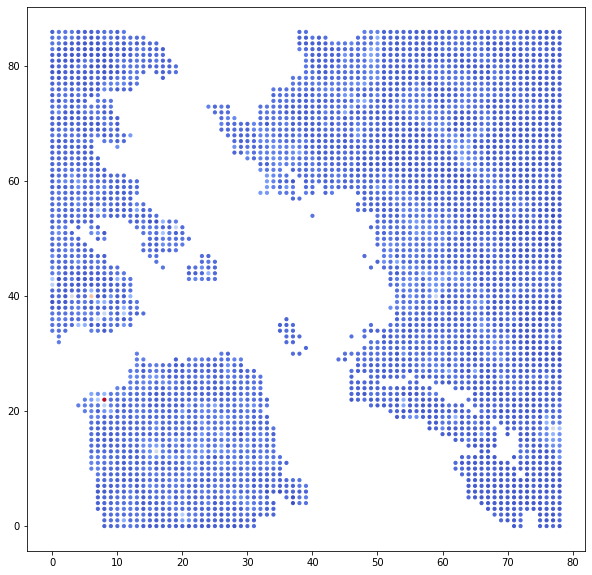

In [75]:
f, a = plt.subplots(figsize = (10,10))
a.scatter(x = df_tmp['x'],
          y = df_tmp['y'],
          c = preds,
          cmap = 'coolwarm',
          s = 10)

(array([3.594e+03, 5.890e+02, 4.300e+01, 9.000e+00, 7.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.3323 ,  4.78735,  9.2424 , 13.69745, 18.1525 , 22.60755,
        27.0626 , 31.51765, 35.9727 , 40.42775, 44.8828 ]),
 <a list of 10 Patch objects>)

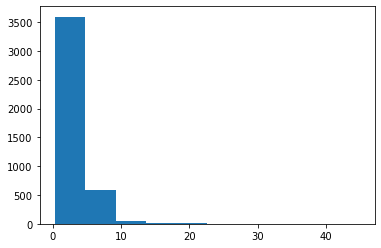

In [78]:
plt.hist(preds)

I mean,that's kind of what our distribution looks like

### what if we log-transform the output

(array([   4.,    6.,   77.,  955., 1859., 1099.,  198.,   35.,    9.,
           2.]),
 array([-1.1017171 , -0.61113993, -0.12056275,  0.37001442,  0.8605916 ,
         1.35116877,  1.84174595,  2.33232312,  2.8229003 ,  3.31347747,
         3.80405465]),
 <a list of 10 Patch objects>)

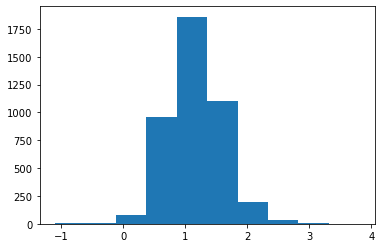

In [79]:
plt.hist(np.log(preds))

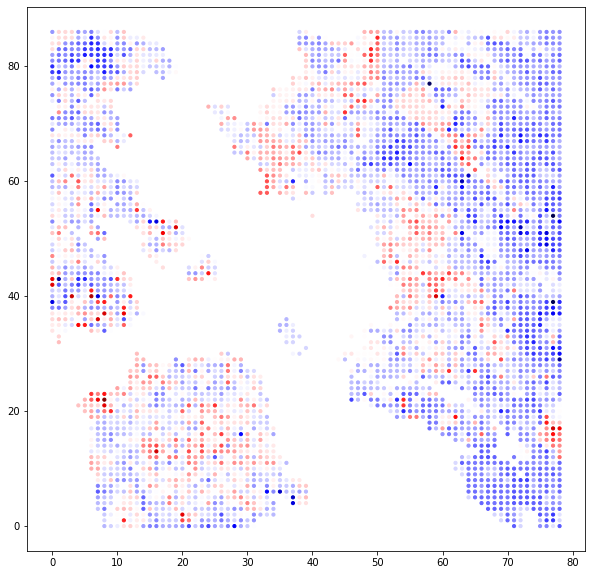

In [81]:
f, a = plt.subplots(figsize = (10,10))
a.scatter(x = df_tmp['x'],
          y = df_tmp['y'],
          c = np.log(preds),
          cmap = 'seismic',
          s = 10)

**that looks better**

# important note, read me
Note the dark red near like, land's end. It's possible there is someone smoking there near a sensor and it's making all the neighbors guess slightly more red than usual. We should drop PA sensor readings over a certain threshold (say, 300) so an outlier reading doesn't throw off all neighbor readings